In [3]:
import cv2
from IPython.display import display, Math, Latex
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
import torch
from pix2text import Pix2Text
import onnxruntime
print(onnxruntime.get_available_providers())

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [4]:
class Box():
    def __init__(self, x1, y1, x2, y2, box_type, box_id, content):
        self.x1 = int(x1)
        self.x2 = int(x2)
        self.y1 = int(y1)
        self.y2 = int(y2)
        self.type = box_type
        self.id = box_id
        self.w = int(x2-x1)
        self.h = int(y2-y1)
        self.area = int(self.w*self.h)
        self.content = content

    def __repr__(self):
        return f"{self.id}"
        
    def get_x_overlap(self, new_x_start): # assuming that the new_start is right of x1
        return (new_x_start - self.x2)

    def get_y_overlap(self, new_y_start):
        return (new_y_start - self.y2) # assuming that new_y_start is below y2

    def get_x_overlap_ratio(self, new_x_start): 
        return float((new_x_start - self.x2)/self.w) # overlap would be positive, offset would be negative

    def get_y_overlap_ratio(self, new_y_start):
        return float((new_y_start - self.y2)/self.h)

    def get_coordinates(self):
        return (self.x1, self.y1, self.x2, self.y2)

In [ ]:
def draw_boxes(image, layout):
    image = Image.fromarray(image)
    color_map = {
        "text": "blue",
        "title": "red",
        "list": "green",
        "table": "purple",
        "figure": "orange"
    }
    
    for key, value in color_map.items():
        print(key, value)
        
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default(30)
    for box in layout:
        x1, y1, x2, y2 = box.coordinates
        box_type, confidence = box.type, box.score
        if confidence < 0.15:
            continue
        if box_type.lower() == "figure" and confidence < 0.5:
            continue
        color = color_map.get(box_type.lower(), "black")
        draw.rectangle((x1, y1, x2, y2), outline=color, width=2)
        # Prepare the confidence label text
        label = f"{confidence:.2f}"
        # Use draw.textbbox to compute the text dimensions.
        bbox = draw.textbbox((0, 0), label, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        
        # Adjust label position with padding.
        label_position = (x2 - text_width, y1)
        
        # Draw a filled rectangle behind the text.
        draw.rectangle([label_position, (x2, y1 + text_height + 12)], fill=color)
        
        # Draw the text label in white; adjust position to account for padding.
        draw.text((label_position[0], label_position[1]), label, fill="white", font=font)
        
    return image

In [3]:
def cv_threshold(image_path, show=False):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    reference_image = rgb_image
    count = 1
    boxes = []
    
    lower = np.array([0, 0, 0])          # minimum color value
    upper = np.array([250, 250, 250])      # anything not quite white
    mask = cv2.inRange(rgb_image, lower, upper)
        
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    dilation_kernel = np.ones((35,35), np.uint8) # increase kernel size if objects are further apart
    dilated_mask = cv2.dilate(mask, dilation_kernel, iterations=1)
    contours, hierarchy = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        x1, y1, w, h = cv2.boundingRect(cnt)
        x2, y2 = x1+w, y1+h
        if show:
            cv2.rectangle(rgb_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        boxes.append(Box(x1, y1, x2, y2, None, count, None))
        count += 1

    lower = np.array([150, 0, 0])  # Strong red in R-channel
    upper = np.array([255, 100, 100])  # Limit green/blue channels
    mask = cv2.inRange(reference_image, lower, upper)

    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    dilation_kernel = np.ones((30,30), np.uint8)
    dilated_mask = cv2.dilate(mask, dilation_kernel, iterations=1)
    contours, hierarchy = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        x1, y1, w, h = cv2.boundingRect(cnt)
        x2, y2 = x1+w, y1+h
        if show:
            cv2.rectangle(rgb_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        boxes.append(Box(x1, y1, x2, y2, None, count, None))
        count += 1

    if show:
        result = Image.fromarray(rgb_image)
        display(result)
    
    return boxes
    
    # plt.figure(figsize=(15,10))
    # plt.subplot(1,3,1)
    # plt.imshow(mask, cmap="gray")
    # plt.title("Original Mask")
    # plt.axis("off")
    
    # plt.subplot(1,3,2)
    # plt.imshow(dilated_mask, cmap="gray")
    # plt.title("Dilated Mask (Merged Regions)")
    # plt.axis("off")
    
    # plt.subplot(1,3,3)
    # plt.imshow(rgb_image)
    # plt.title("Merged Bounding Boxes")
    # plt.axis("off")
    # plt.show()

In [ ]:
for x in range(16):
    _ = cv_threshold(f"page-{x}.png", show=True)

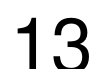

final result:  © University of British Columbia — Manufacturing Automation Laboratory Prof. Yusuf Altintas


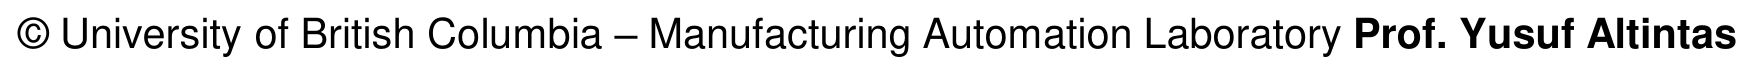

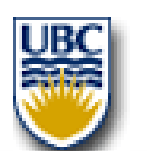

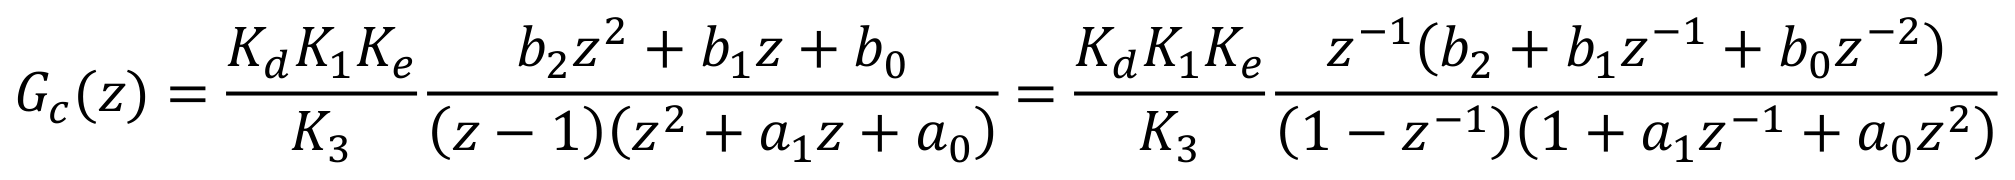

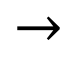

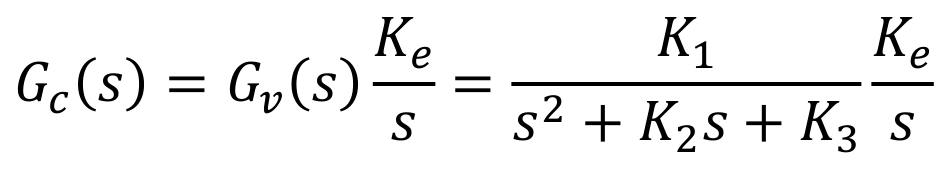

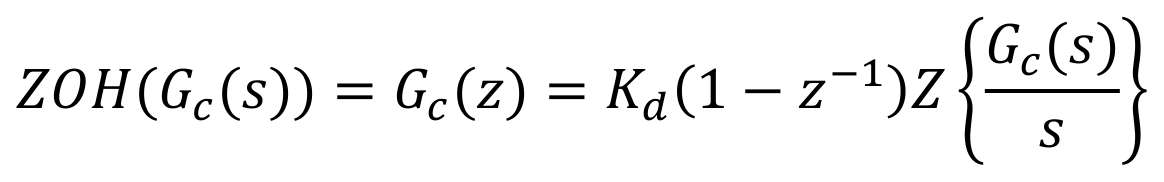

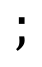

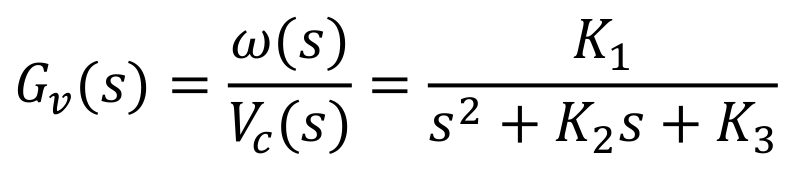

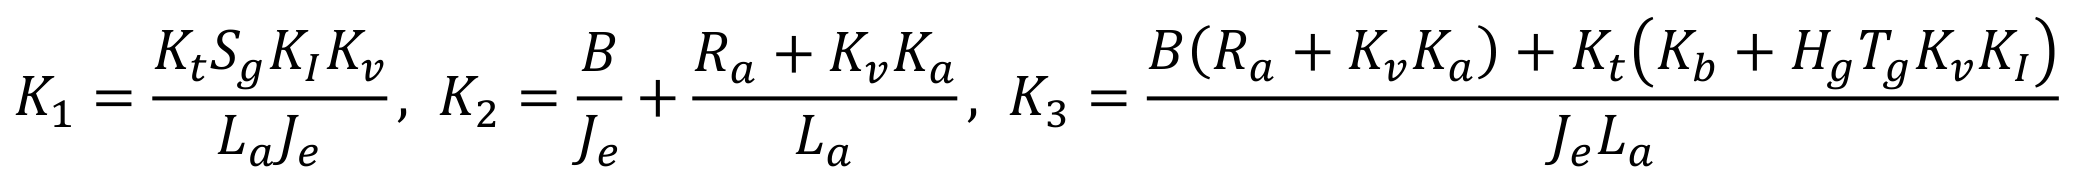

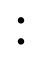

final result:  D/A Gain


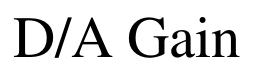

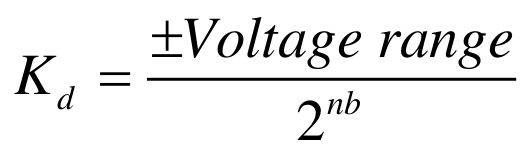

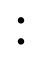

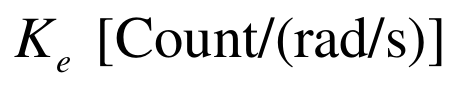

final result:  Encoder gain


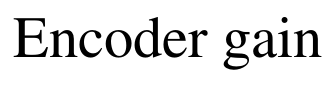

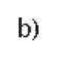

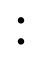

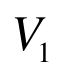

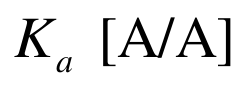

final result:  Current feedback gain


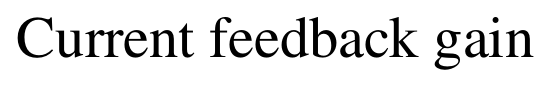

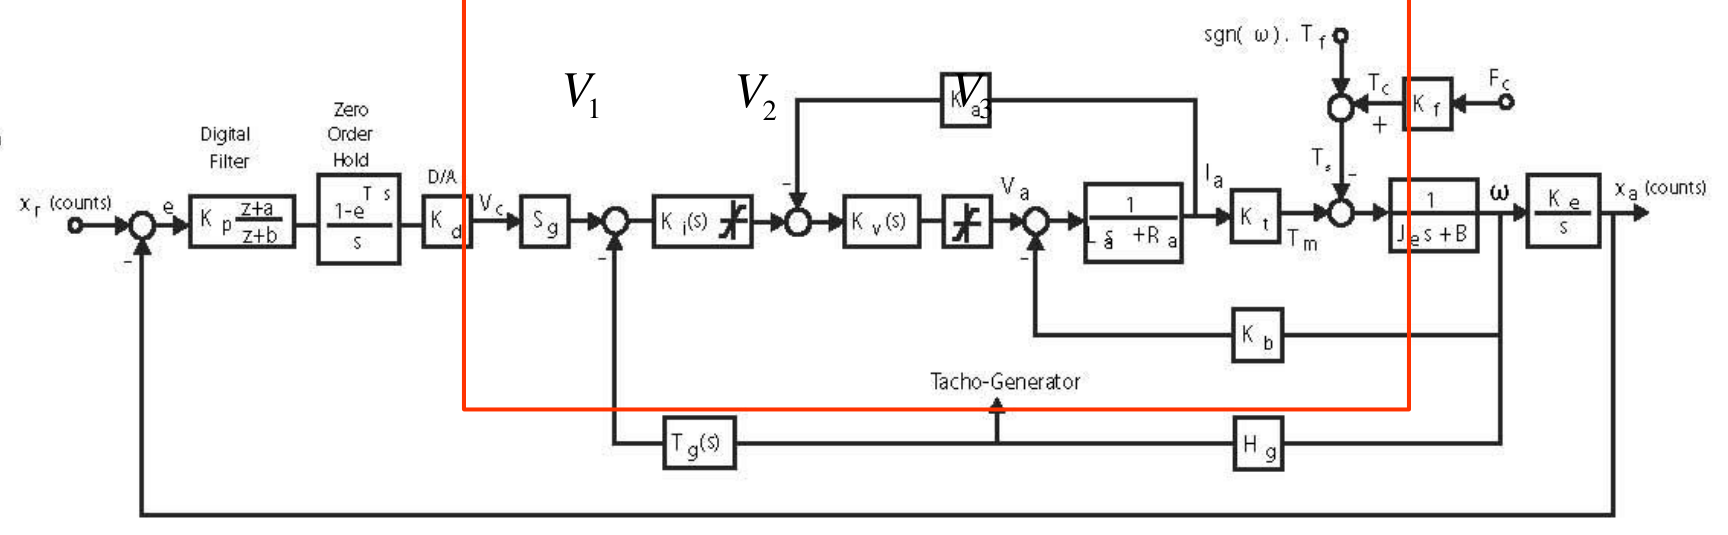

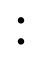

final result:  K, [A/V]


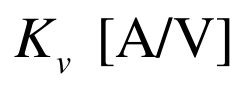

final result:  PWM amplifier gain


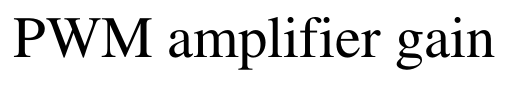

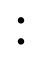

final result:  K, [V/A]


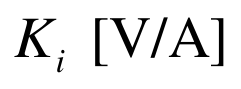

final result:  Current amplifer gain


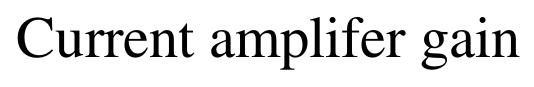

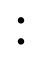

final result:  S, [V/V]


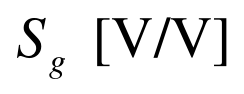

final result:  Amplifier signal gain


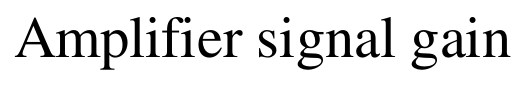

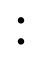

final result:  T, [V/V]


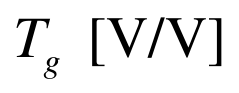

final result:  Tacho op. amp gain


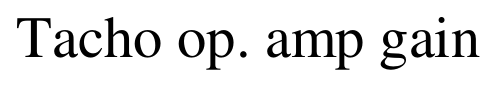

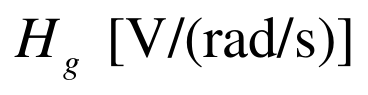

final result:  Tachogenerator constant :


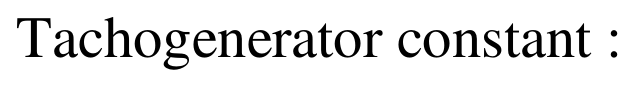

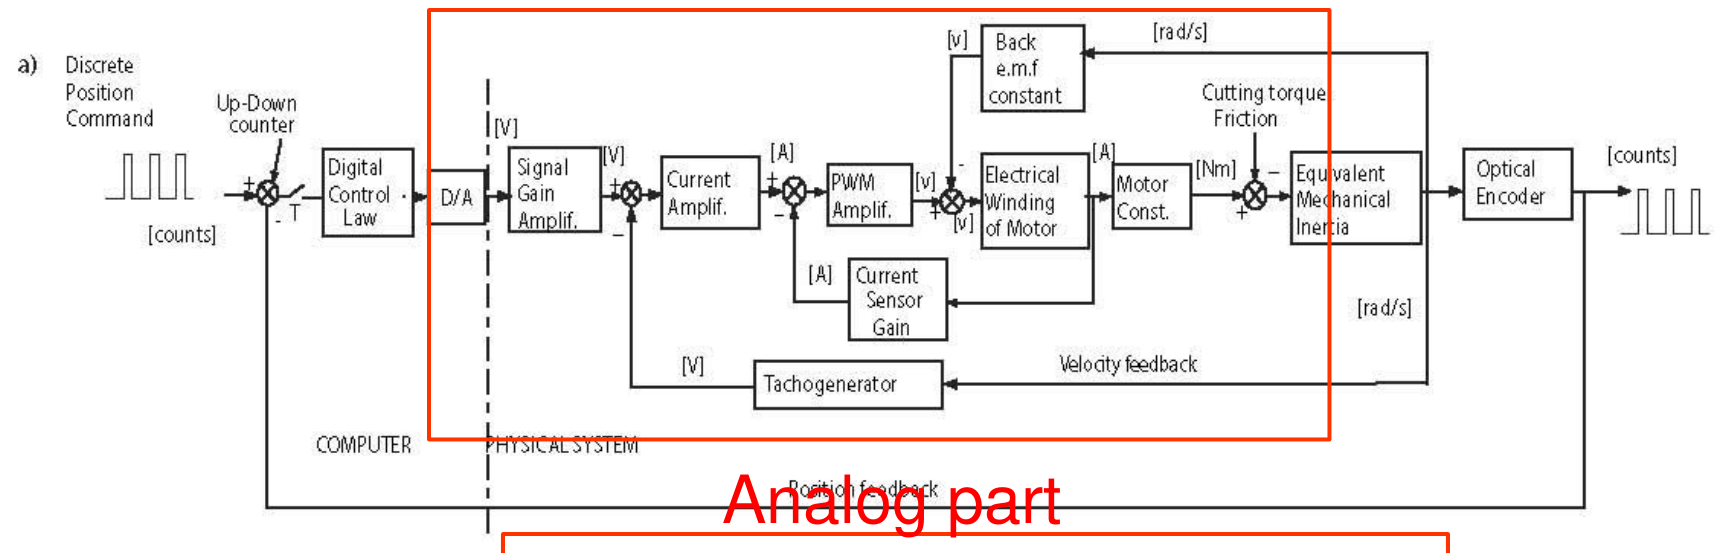

final result:  Closed loop transfer function of drive in z domain


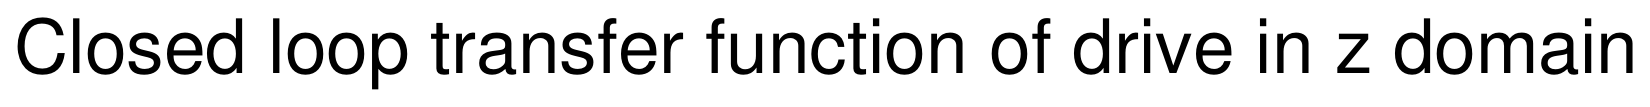

KeyboardInterrupt: 

In [9]:
def classify_element(box, image_path):
    x1, y1, x2, y2 = box.get_coordinates()
    image = Image.open(image_path)
    cropped_img = image.crop((x1, y1, x2, y2))
    total_area = box.area
    text = pytesseract.image_to_string(cropped_img)
    data = pytesseract.image_to_data(cropped_img, output_type='dict')
    confidences, texts, num_elements, widths, heights = data['conf'], data['text'], len(data['conf']), data['width'], data['height']
    result_string = ""
    sum_area = 0
    for index, zipped in enumerate(zip(confidences, texts, widths, heights)):
        conf, text, width, height = zipped
        if conf == -1 or text == "":
            continue
        if conf >= 80:
            left = (True if confidences[index-1] >= 90 else False) if index-1 >= 0 else False
            right = (True if confidences[index+1] >= 90 else False) if index+1 < num_elements else False
            if (left or right): # either neighbor has high confidence and you have decent
                result_string = result_string + " " + text
                sum_area += width * height
    if sum_area / total_area >= 0.2: # result_string contains chars for latex instead
        print(f"final result: {result_string}")
    display(cropped_img)

#     # Heuristic: Aspect Ratio
#     aspect_ratio = w / h

#     # Classification Rules
#     if contains_math or (text_density > 0.02 and aspect_ratio > 3.0):
#         return "Equation"
#     elif contains_figure_keyword or (text_density < 0.015 and aspect_ratio < 1.5):
#         return "Figure"
#     else:
#         return "Text"

# # Apply classification
# filtered_elements = []
# for element in layout:
#     classification = classify_element(element, image)
#     if classification != "Figure":
#         filtered_elements.append(element)

boxes = cv_threshold("page-12.png")
for box in boxes:
    classify_element(box, "page-12.png")

In [ ]:
img = Image.new("RGB", image_size, "white")  # Create a white background
draw = ImageDraw.Draw(img)

colors = ["red", "blue", "green", "purple", "orange"]  # Color choices
for i, (x1, y1, x2, y2) in enumerate(boxes):
    color = colors[i % len(colors)]  # Cycle through colors
    draw.rectangle([x1, y1, x2, y2], outline=color, width=2)

print(title)
display(img)  # Show image in Jupyter Notebook

In [ ]:
from im2latex import Im2LatexModel
im2latex_model = Im2LatexModel.from_pretrained("google/im2latex-base")  # Load im2latex model

if not torch.cuda.is_available():
    print("Warning: Running im2latex on CPU. This may be slow.")

image = image.convert("RGB")  # Ensure it's in RGB mode
latex_formula = im2latex_model(image)  # Perform OCR
return latex_formula

In [4]:
pix2text_model = Pix2Text()  # Load Pix2Text model

# boxes = cv_threshold("page-12.png")
# box = boxes[3]
# for box in boxes:
# x1, y1, x2, y2 = box.get_coordinates()
# cropped_image = image_gray.crop((x1-70, y1, x2+10, y2))
# latex_formula = pix2text_model(cropped_image)  # Perform OCR

def pix2text_transcibe(image_path, show=False):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    image_gray = image.convert("L")  # Convert to grayscale for better OCR
    latex_formula = pix2text_model(image_gray)  # Perform OCR
    # print(latex_formula)
    for element in latex_formula.elements:
        # if (element.kwargs['text_contain_formula']):
        # print(element.box)
        # print(element.text)
        # print(element.type)
        # print(element.score)
        x1,y1,x2,y2 = element.box
        if show:
            draw.rectangle((x1, y1, x2, y2), outline="green", width=2)
        # cropped_image = image.crop((x1, y1, x2, y2))
        # display(cropped_image)
        # display(Math(element.text))
        
    if show:
        display(image)
    return element.text

/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/download.py:139: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Download complete. Moving file to /root/.pix2text/1.1/layout-docyolo/.gitattributes
Fetching 4 files:  25%|██▌       | 1/4 [00:00<00:01,  2.92it/s]Downloading 'doclayout_yolo_docstructbench_imgsz1024.pt' to '/root/.pix2text/1.1/layout-docyolo/.cache/huggingface/download/Evz14ljriAnod82wdQvLGI7lD78=.9a2ee0220fe3d9ad31b47e1d9f1282f46959a54e4618fce9cffcc9715b8286e2.incomplete'
Download complete. Moving file to /root/.pix2text/1.1/layout-docyolo/con

/root/.pix2text/1.1/layout-docyolo


2025-04-02 00:30:32.190318993 [W:onnxruntime:, transformer_memcpy.cc:83 ApplyImpl] 1 Memcpy nodes are added to the graph torch_jit for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
[WARNING 2025-04-02 00:30:32,263 _assert_and_prepare_model_files:109] can not find model file /root/.cnstd/1.2/ppocr/ch_PP-OCRv4_det/ch_PP-OCRv4_det_infer.onnx 
/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/download.py:139: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 4 files:

/root/.cnstd/1.2/ppocr/ch_PP-OCRv4_det


/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/download.py:139: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]Downloading 'README.md' to '/root/.pix2text/1.1/mfd-onnx/.cache/huggingface/download/Xn7B-BWUGOee2Y6hCZtEhtFu4BE=.61d977325e525789c0cdca133d287ecb9b2f37bf.incomplete'
Download complete. Moving file to /root/.pix2text/1.1/mfd-onnx/config.yaml
Download complete. Moving file to /root/.pix2text/1.1/mfd-onnx/README.md
Download complete. Moving file to /root/.pix2text/1.1/mfd-onnx/.gitattributes
Fetching 4 files: 100%|██████████| 4/4 [00:03<00:00,  1.

/root/.pix2text/1.1/mfd-onnx


/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/download.py:139: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]Downloading 'special_tokens_map.json' to '/root/.pix2text/1.1/mfr-onnx/.cache/huggingface/download/ahkChHUJFxEmOdq5GDFEmerRzCY=.b1879d702821e753ffe4245048eee415d54a9385.incomplete'
Download complete. Moving file to /root/.pix2text/1.1/mfr-onnx/special_tokens_map.json
Download complete. Moving file to /root/.pix2text/1.1/mfr-onnx/preprocessor_config.json
Download complete. Moving file to /root/.pix2text/1.1/mfr-onnx/.gitattributes
Fetching 10 f

/root/.pix2text/1.1/mfr-onnx


2025-04-02 00:30:47.108027702 [W:onnxruntime:, session_state.cc:1263 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-04-02 00:30:47.108055224 [W:onnxruntime:, session_state.cc:1265 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2025-04-02 00:30:47.266631942 [W:onnxruntime:, session_state.cc:1263 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-04-02 00:30:47.266663228 [W:onnxruntime:, session_state.cc:1265 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2025-04-02 00:30:47.390291924 [W:onnxrun

In [ ]:
for x in range(16):
    _ = pix2text_transcibe(f"page-{x}.png", show=True)

In [ ]:
def merge_boxes(boxes, horizontal_thres=5, vertical_thres=5, area_thres=0.3):
    x_merge = set()
    y_merge = set()
    merged = False
        
    x_sorted_boxes = sorted(boxes, key=lambda x: x.x1)
    print(x_sorted_boxes)
    for index in range(1, len(x_sorted_boxes)):
        old_box, new_box = x_sorted_boxes[index-1], x_sorted_boxes[index]
        if old_box.type == new_box.type: # if same type, lenient, can connect sideways
            x_overlap = old_box.get_x_overlap(new_box.x1)
            if x_overlap <= 0 or abs(x_overlap) <= horizontal_thres: # if they overlap or are within range
                x_merge.add(((min(old_box.id, new_box.id), max(old_box.id, new_box.id))))
        else: # if not the same type, need very high overlap
            overlap_ratio = max(old_box.get_x_overlap_ratio(new_box.x1), new_box.get_x_overlap_ratio(old_box.x2))
            if overlap_ratio >= area_thres:
                x_merge.add(((min(old_box.id, new_box.id), max(old_box.id, new_box.id))))

    y_sorted_boxes = sorted(boxes, key=lambda x: x.y1)
    print(y_sorted_boxes)
    for index in range(1, len(y_sorted_boxes)):
        old_box, new_box = y_sorted_boxes[index-1], y_sorted_boxes[index]
        if old_box.type == new_box.type: # if same type, lenient, can connect sideways
            y_overlap = old_box.get_y_overlap(new_box.y1)
            if y_overlap <= 0 or abs(y_overlap) <= vertical_thres: # if they overlap or are within range
                y_merge.add(((min(old_box.id, new_box.id), max(old_box.id, new_box.id))))
        else: # if not the same type, need very high overlap
            overlap_ratio = max(old_box.get_y_overlap_ratio(new_box.y1), new_box.get_y_overlap_ratio(old_box.y2))
            if overlap_ratio >= area_thres:
                y_merge.add(((min(old_box.id, new_box.id), max(old_box.id, new_box.id))))

    union_set = x_merge | y_merge
    print(union_set)

    # dictionary comprehension for lookup table, telling you what ids to use as each box gets merged...
    # update the list by subtituting the box ids with the one you replace, only the first one though, this should make it grow smaller...
    # turn the list into a set, it doesnt matter if you add them everywhere, dont need to check either, you are just converting boxes w/ inheritance
    # you change this dict as you merge, 

    # can just make the resulting list from set from the dict.values()
    
    # for each pair, make biggest box possible, replace the earlier occuring id -> how to handle the fact that two consecutive merges happen?
    # make substitute list or copy, compare the new value against that if you dont have the reference anymore -> map of old ids to new merged ids
    # this way you can compare, you will take the id of the larger area box and use that as template to expand bounds...
    
    if merged: # call func again with resulting boxes 
        # make a new box list from resulting changes
        pass

merge_boxes([Box(1,3,1,3,"blah", 0), Box(2,4,1,3,"blah", 1)])

merge_boxes([Box(10,10,50,50,"l",0,None), Box(0,20,20,40,"l",1,None), Box(60,60,100,100,"l",2,None), Box(65,65,95,95,"l",3,None)])